In [10]:
from google.colab import files
uploaded = files.upload()

In [4]:
!tar xvzf fer2013.tar.gz

fer2013/fer2013.csv
fer2013/README
fer2013/fer2013.bib
fer2013/


In [1]:
import pandas as pd
import io
  
df = pd.read_csv('fer2013/fer2013.csv')
print(df)

       emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            2  231 212 156 164 174 138 161 173 182 200 106 38...     Training
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...     Training
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...     Training
...        ...                                                ...          ...
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

[35887 rows x 3 columns]


In [2]:
pip install utils

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
import pandas as pd
%matplotlib inline
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.4.1


In [4]:
def string2array(x):
    return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

In [5]:
df['pixels'] = df['pixels'].apply(lambda x: string2array(x))

In [6]:
def convert(img, target_type_min, target_type_max, target_type):
    imin = img.min()
    imax = img.max()

    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    return new_img

In [7]:
for i in range(len(df['pixels'])):
    df['pixels'][i]=np.repeat(df['pixels'][i].reshape(48,48,1), 3, axis=2)
    df['pixels'][i]=convert(df['pixels'][i], 0, 255, np.uint8)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: Runtim

In [8]:
df.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

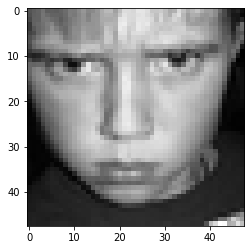

In [9]:
p= (df['pixels'][900]).reshape(48,48,3)
plt.imshow(p)

In [10]:
emotion_dict = {0:'anger', 1:'disgust', 2:'fear', 3:'happy', 4: 'sad',5:'surprise',6:'neutral'}
#emojis unicodes
emojis = { 0:"\U0001f620",1:"\U0001f922" ,2:"\U0001f628" ,3:"\U0001f60A" , 4:"\U0001f625" ,5:"\U0001f632",6:"\U0001f610" }
print(emojis.values(),sep=' ')

dict_values(['😠', '🤢', '😨', '😊', '😥', '😲', '😐'])


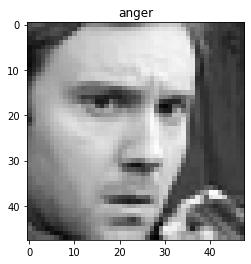

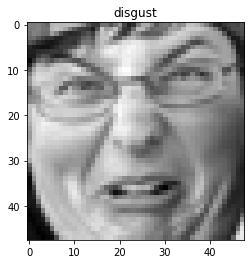

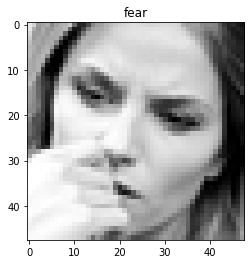

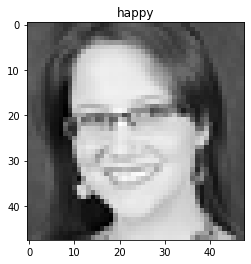

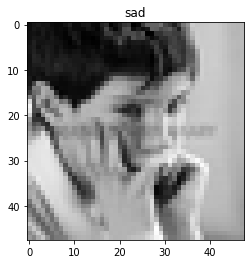

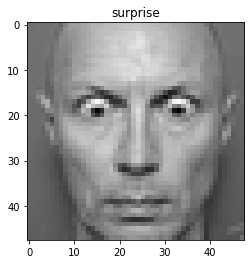

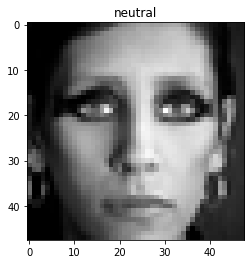

In [11]:
emotions = [0,1,2,3,4,5,6]

for i in emotions:
    data = df[df['emotion'] == i][:1]
    img = data['pixels'].item()
    img = img.reshape(48,48,3)
    plt.figure()
    plt.title(emotion_dict[i])
    plt.imshow(img, cmap= 'gray')

Text(0.5, 1.0, 'Number of images per emotion')

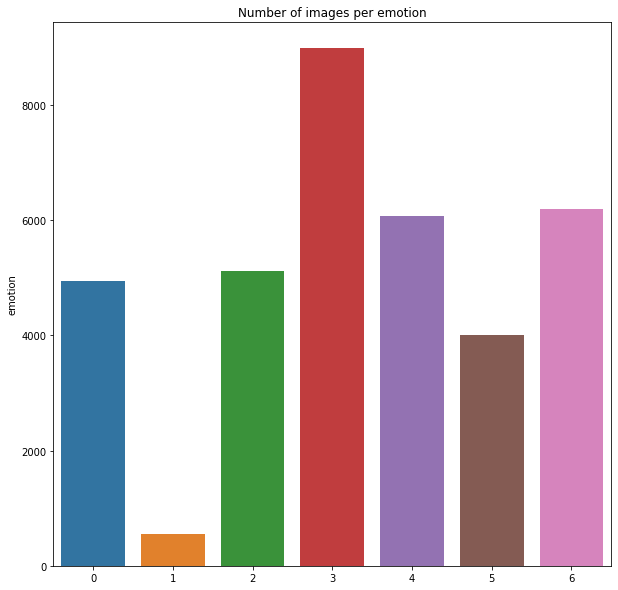

In [12]:
plt.figure(figsize=(10,10))
sns.barplot(x=df.emotion.value_counts().index,y=df.emotion.value_counts())
plt.title('Number of images per emotion')

In [13]:
x = df['pixels']
x=np.stack(x, axis = 0)
x = x.reshape(35887, 48, 48, 3)
y = pd.get_dummies(df['emotion'])


In [14]:
x

array([[[[ 75,  75,  75],
         [ 88,  88,  88],
         [ 90,  90,  90],
         ...,
         [ 52,  52,  52],
         [ 41,  41,  41],
         [ 38,  38,  38]],

        [[ 69,  69,  69],
         [ 64,  64,  64],
         [ 60,  60,  60],
         ...,
         [ 57,  57,  57],
         [ 52,  52,  52],
         [ 42,  42,  42]],

        [[ 49,  49,  49],
         [ 41,  41,  41],
         [ 55,  55,  55],
         ...,
         [ 48,  48,  48],
         [ 57,  57,  57],
         [ 46,  46,  46]],

        ...,

        [[102, 102, 102],
         [ 69,  69,  69],
         [ 39,  39,  39],
         ...,
         [ 78,  78,  78],
         [ 57,  57,  57],
         [ 41,  41,  41]],

        [[ 84,  84,  84],
         [ 90,  90,  90],
         [ 87,  87,  87],
         ...,
         [120, 120, 120],
         [ 75,  75,  75],
         [ 44,  44,  44]],

        [[ 84,  84,  84],
         [ 78,  78,  78],
         [ 93,  93,  93],
         ...,
         [121, 121, 121],
        

In [15]:
x = np.array(x)
y = np.array(y)

In [16]:
x.dtype

dtype('uint8')

In [17]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, shuffle = True)
x_valid, x_test, y_valid, y_test = train_test_split(x_test,y_test, test_size = 0.5, shuffle = True)

train_data = (x_train, y_train)
valid_data = (x_valid, y_valid)
test_data =  (x_test, y_test)

In [18]:
x_train= x_train/255
x_train = x_train-0.5
x_train = x_train*2.0

In [19]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_valid.shape, y_valid.shape)

(28709, 48, 48, 3) (28709, 7)
(3589, 48, 48, 3) (3589, 7)
(3589, 48, 48, 3) (3589, 7)


In [28]:
import keras
train_datagen = ImageDataGenerator(preprocessing_function=keras.applications.resnet50.preprocess_input,
rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode = "nearest", 
    vertical_flip=True,
)

In [29]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(input_shape=(48, 48, 3), include_top=False, weights="imagenet")

# freeze all layers in the base model
base_model.trainable = False

# un-freeze the BatchNorm layers
for layer in base_model.layers:
    if "BatchNormalization" in layer.__class__.__name__:
        layer.trainable = True



In [30]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 54, 54, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 24, 24, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [33]:
#input_shape = (48, 48, 1)

# Input tensor shape
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))

In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
dropout_4 (Dropout)          (None, 2, 2, 2048)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                262176    
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
activation_2 (Activation)    (None, 32)               

In [35]:
model.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [36]:
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)
reduce_lr=ReduceLROnPlateau(monitor='val_loss',factor=0.1, patience=2,min_lr=0.00001,mode='auto')
# Saving the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath = "FacialExpression_weights.hdf5", verbose = 1, save_best_only=True)

In [37]:
history = model.fit(train_datagen.flow(x_train, y_train, batch_size=64),
	validation_data=(x_valid, y_valid), verbose=1,
	epochs= 100, callbacks=[reduce_lr,checkpointer, earlystopping])

Epoch 1/100
449/449 [==============================] - 363s 795ms/step - loss: 2.1890 - accuracy: 0.2226 - val_loss: 204.0052 - val_accuracy: 0.2541

Epoch 00001: val_loss improved from inf to 204.00525, saving model to FacialExpression_weights.hdf5
Epoch 2/100
449/449 [==============================] - 353s 786ms/step - loss: 1.8575 - accuracy: 0.2473 - val_loss: 129.5315 - val_accuracy: 0.2541

Epoch 00002: val_loss improved from 204.00525 to 129.53149, saving model to FacialExpression_weights.hdf5
Epoch 3/100
  9/449 [..............................] - ETA: 5:15 - loss: 1.8319 - accuracy: 0.2342

KeyboardInterrupt: ignored

In [28]:
score = model.evaluate(x_test, y_test)
print('Test Accuracy: {}'.format(score[1]))

113/113 [==============================] - 33s 295ms/step - loss: 2.8709 - accuracy: 0.1817
Test Accuracy: 0.18166619539260864


In [29]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

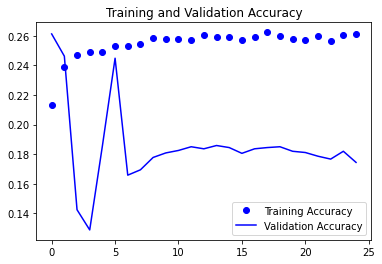

In [30]:
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

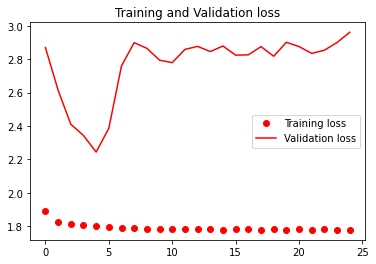

In [31]:
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

In [32]:
predicted_classes = np.argmax(model.predict(x_test), axis=-1)
y_true = np.argmax(y_test,axis = 1)

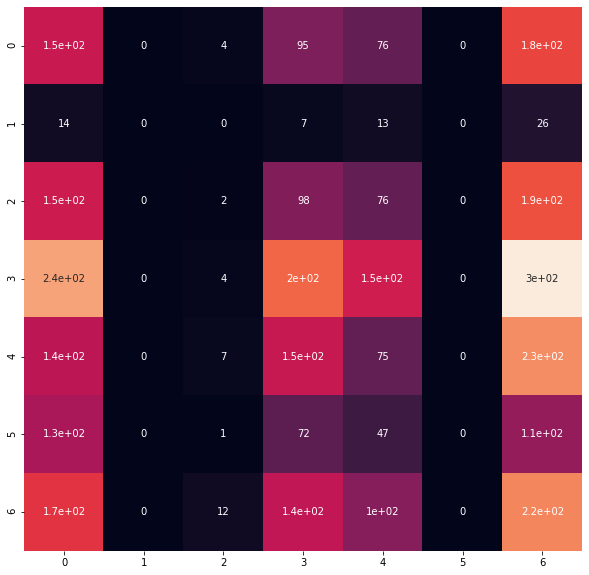

In [33]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True, cbar = False)

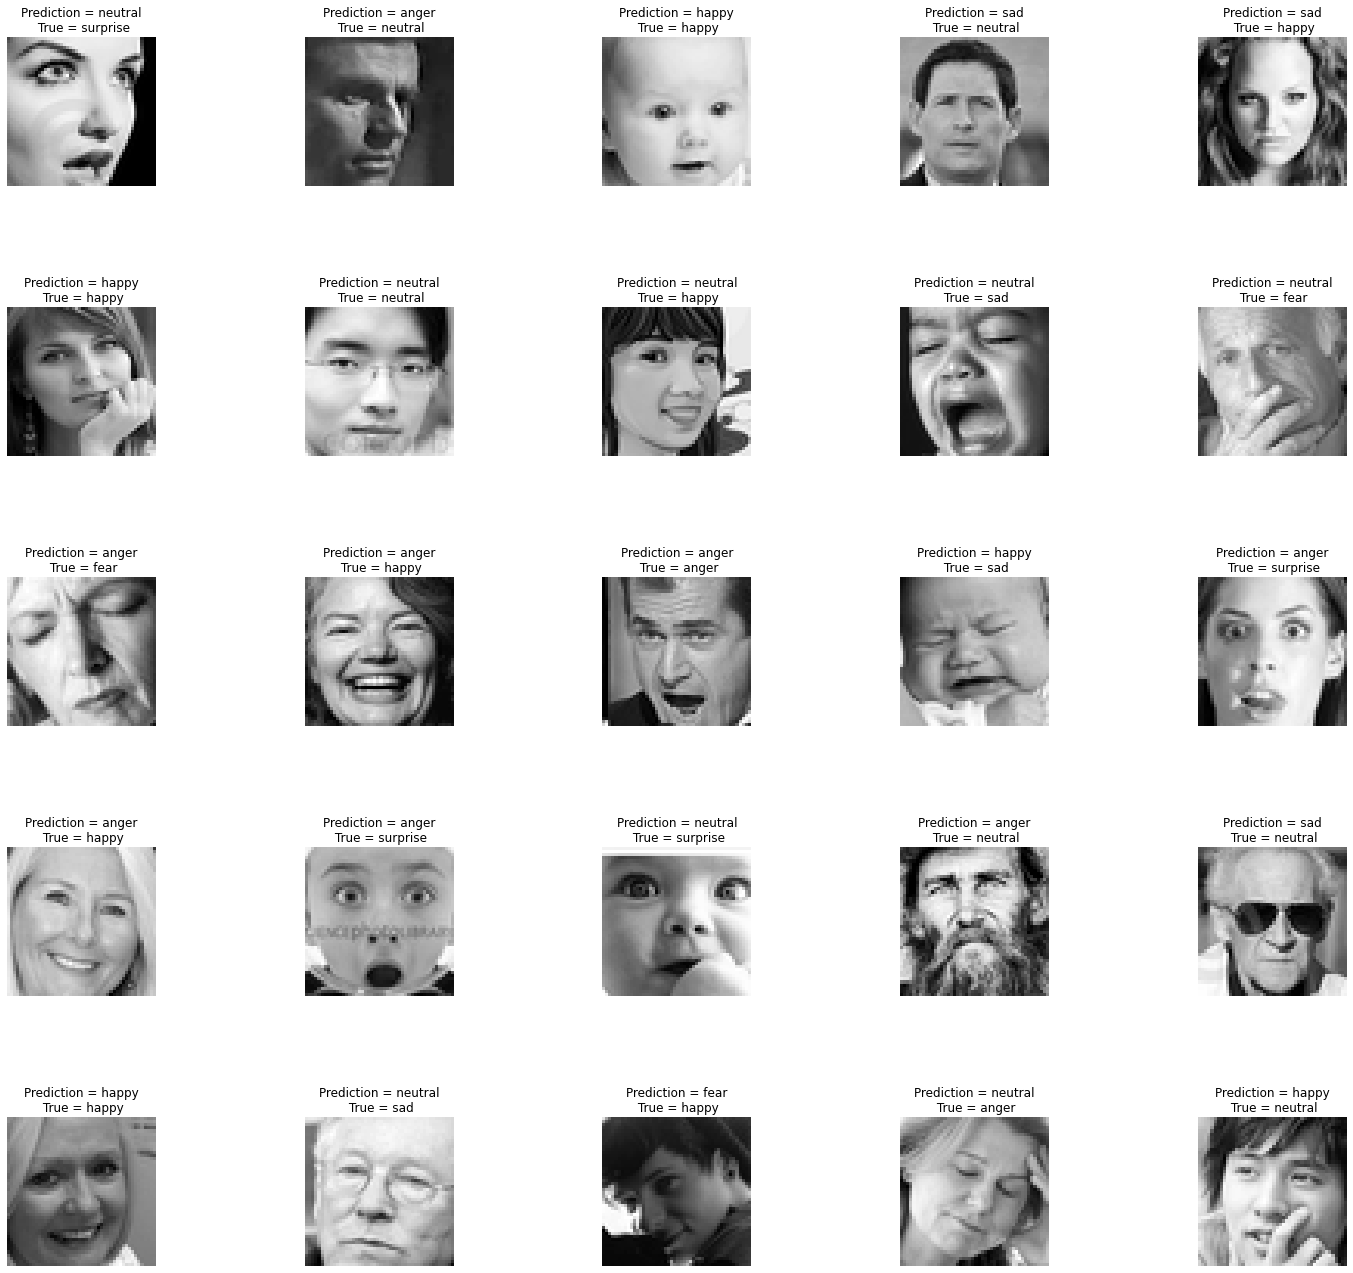

In [34]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (24, 24))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(x_test[i].reshape(48,48,3), cmap = 'gray')
    axes[i].set_title('Prediction = {}\n True = {}'.format(emotion_dict [predicted_classes[i]], emotion_dict [y_true[i]]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1)

In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_true, predicted_classes))

              precision    recall  f1-score   support

           0       0.15      0.29      0.20       506
           1       0.00      0.00      0.00        60
           2       0.07      0.00      0.01       516
           3       0.27      0.23      0.24       902
           4       0.14      0.13      0.13       596
           5       0.00      0.00      0.00       359
           6       0.18      0.34      0.23       650

    accuracy                           0.18      3589
   macro avg       0.11      0.14      0.12      3589
weighted avg       0.15      0.18      0.15      3589



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
import cv2

def predict(path):
  facecasc = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')
  imagePath = '/content/'+path
  image = cv2.imread(imagePath)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  faces = facecasc.detectMultiScale(gray,scaleFactor=1.3, minNeighbors=10)
  print("No of faces : ",len(faces))
  i = 0
  for (x, y, w, h) in faces:
    i=i+1
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    roi_gray = gray[y:y + h, x:x + w]                      #croping
    cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
    print(cropped_img)
    prediction = model_emotion.predict(cropped_img)
    print(prediction)

    maxindex = int(np.argmax(prediction))
    print("person ",i," : ",emotion_dict[maxindex], "-->",emojis[maxindex])
    cv2.putText(image, emotion_dict[maxindex], (x+10, y-20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)  
                                              #if text is not apeared , change coordinates. it may work
  
  import matplotlib.pyplot as plt
  # load image using cv2....and do processing.
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  # as opencv loads in BGR format by default, we want to show it in RGB.
  plt.show()

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving download (1).jpeg to download (1).jpeg


No of faces :  1
[[[[182]
   [180]
   [163]
   ...
   [182]
   [179]
   [181]]

  [[187]
   [190]
   [172]
   ...
   [190]
   [193]
   [182]]

  [[191]
   [184]
   [150]
   ...
   [181]
   [188]
   [192]]

  ...

  [[189]
   [186]
   [188]
   ...
   [202]
   [201]
   [201]]

  [[195]
   [177]
   [185]
   ...
   [207]
   [212]
   [195]]

  [[186]
   [195]
   [192]
   ...
   [197]
   [207]
   [207]]]]
[[0. 0. 0. 0. 0. 0. 1.]]
person  1  :  neutral --> 😐


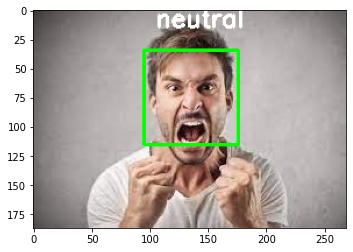

In [ ]:
predict('download (1).jpeg')

No of faces :  0


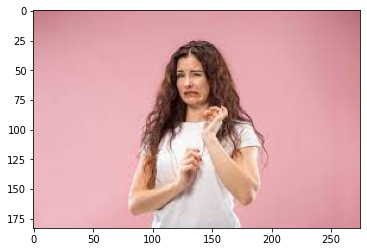

In [ ]:
predict('download.jpeg')

No of faces :  0


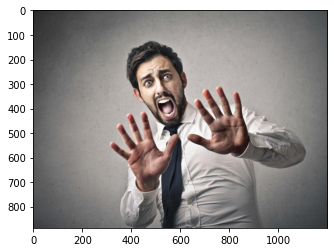

In [ ]:
predict('fearistock000053370614bowie15.jpeg')

No of faces :  0


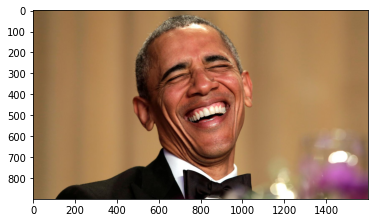

In [ ]:
_predict('rtx2c9ws.jpeg')

No of faces :  1
person  2  :  neutral --> 😐


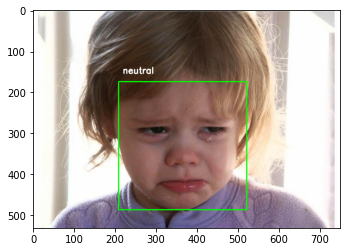

In [ ]:
_predict('sad.jpeg')

In [ ]:
# Saving the model architecture to json file for future use

model_json = model_emotion.to_json()
with open("Emotion-model.json","w") as json_file:
  json_file.write(model_json)

In [ ]:
with open('Emotion-model.json', 'r') as json_file:
    json_savedModel= json_file.read()
    
# load the model architecture 
model_emotion = tf.keras.models.model_from_json(json_savedModel)
model_emotion.load_weights('FacialExpression_weights.hdf5')
model_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])